In [1]:
%matplotlib widget
from reconstruction import reconstruct_vols_from_imgs
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, recording_to_overlay_preview, showvid, get_lenses, array3d_to_video
from widgets import get_mask_widget, ortho_views_widget, play_video_widget
cmap = "gray"

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# pn_psf = r"Y:/hpc/r/lfm2025/psfs"
pn_psfs = r"~/hpc-rw/lfm/psfs"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_psfs, '*'))), reverse=True) if os.path.exists(os.path.join(pn_psfs, rec, 'psf.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250701_1216_PSF_LB_noap_old
20250701_1216_PSF_LB_noap_1
20250610_1636_PSF_LB_30k_wo_coverslip_1
20250530_1330_PSF_LB_redFB_1-30K_dim_isolated
20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3


In [3]:
pn_bg = r"~/hpc-rw/lfm/bg"
for file in sorted(pathlib.Path(os.path.expanduser(pn_bg)).iterdir()):
    if file.is_file() and file.suffix == '.npy':
        print(file.name)

20250602_1749_LB_bg_100s.npy
20250602_1749_LB_bg_100s_100laser_2fps.npy
20250602_1753_LB_bg_200s.npy
20250602_1753_LB_bg_200s_100laser_2fps.npy
20250610_1904_80laser_5fps.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.npy
20250611_1508_LB_40fps_100laser_bg.npy
20250611_1508_LB_80fps_100laser_bg.npy
20250701_1649_LB_bg_80fps.npy
20250701_1651_LB_bg_40fps.npy
20250701_1654_LB_bg_2fps.npy
20250729_1146_LB_DC1_5dpf_backfill_1_bg.npy
20250729_1200_LB_DC1_5dpf_backfill_bg_wap_40fps.npy
20250729_1233_LB_DC4_5dpf_backfill_bg_2fps.npy
20250729_1600_LB_DC8_5dpf_backfill_bg_2fps.npy
20250729_1605_LB_DC8_5dpf_backfill_bg_2.npy
20250730_1553_LB_25x_5fps_bg.npy


In [4]:
# pn_rec = r"Y:/hpc/r/lfm2025/recordings"
pn_rec = r"~/hpc-r/lfm2025/recordings"
includes = ['']
excludes = ["bg"]

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'data.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250729_1557_LB_DC8_5dpf_backfill_1_2fps
20250729_1553_LB_DC8_5dpf_backfill_1
20250729_1227_LB_DC4_5dpf_backfill_2_40fps
20250729_1225_LB_DC4_5dpf_backfill_1_2fps
20250729_1155_LB_DC1_5dpf_backfill_4_wap_5fps
20250729_1153_LB_DC1_5dpf_backfill_3_wap
20250729_1150_LB_DC1_5dpf_backfill_2_wap
20250729_1143_LB_DC1_5dpf_backfill_1
20250701_1638_LB_ZF_v552_f7_40fps_tail
20250701_1636_LB_ZF_v552_f7_80fps_tail
20250701_1633_LB_ZF_v552_f7_80fps_3
20250701_1630_LB_ZF_v552_f7_80fps_2
20250701_1628_LB_ZF_v552_f7_80fps_1
20250701_1625_LB_ZF_v552_f7_40fps_2
20250701_1622_LB_ZF_v552_f7_40fps_1
20250701_1613_LB_ZF_v552_f6_80fps_2
20250701_1610_LB_ZF_v552_f6_80fps_1
20250701_1607_LB_ZF_v552_f6_40fps_2
20250701_1605_LB_ZF_v552_f6_40fps_1
20250701_1602_LB_ZF_v552_f6_40fps_tail2
20250701_1600_LB_ZF_v552_f6_40fps_tail
20250701_1547_LB_ZF_v552_f5_80fps_2
20250701_1544_LB_ZF_v552_f5_80fps_1
20250701_1541_LB_ZF_v552_f5_40fps_2
20250701_1538_LB_ZF_v552_f5_40fps_1
20250701_1522_LB_ZF_v552_f4_80fps_1
20250701_1

In [2]:
import i_o
importlib.reload(i_o)
from i_o import Paths

pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1541_LB_ZF_v552_f5_40fps_2"
psf_name = "20250701_1216_PSF_LB_noap_old"
bg_name = "20250701_1651_LB_bg_40fps.npy"

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

In [3]:
psf_f = lazyh5(paths.psf)
crop = np.array(psf_f["crop"])
mask = np.array(psf_f["circle_mask"][crop[0]:crop[1],crop[2]:crop[3]])
psf = np.array(psf_f["psf"])
zpos=np.array(psf_f["z_positions"])

print(psf.shape)

# fig, ax = plt.subplots(1,1,figsize = (7,7))
# ax.imshow(create_projection_image(psf, scalebar=200,zpos=zpos, text= "raw PSF", text_size=4), cmap='gray')
# ax[1].imshow(create_projection_image(psf["psf"]-bg,np.max,pad=10), cmap='binary')

(225, 2048, 2048)


In [ ]:
print(og_crop, og_crop[1]-og_crop[0],og_crop[3]-og_crop[2])
better_crop = os.path.expanduser(os.path.join(pn_psfs, "20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1","psf.h5"))
with h5py.File(better_crop,"r") as f:
    crop = list(f["crop"])
    og_mask=np.array(f["circle_mask"])
print(crop, crop[1]-crop[0],crop[3]-crop[2])
plt.imshow(og_mask[crop[0]:crop[1],crop[2]:crop[3]])


In [ ]:
crop[0]=crop[0]-1
crop[2]=crop[2]-1
print(crop, crop[1]-crop[0],crop[3]-crop[2])
mask = og_mask[crop[0]:crop[1],crop[2]:crop[3]]

20250701_1541_LB_ZF_v552_f5_40fps_2


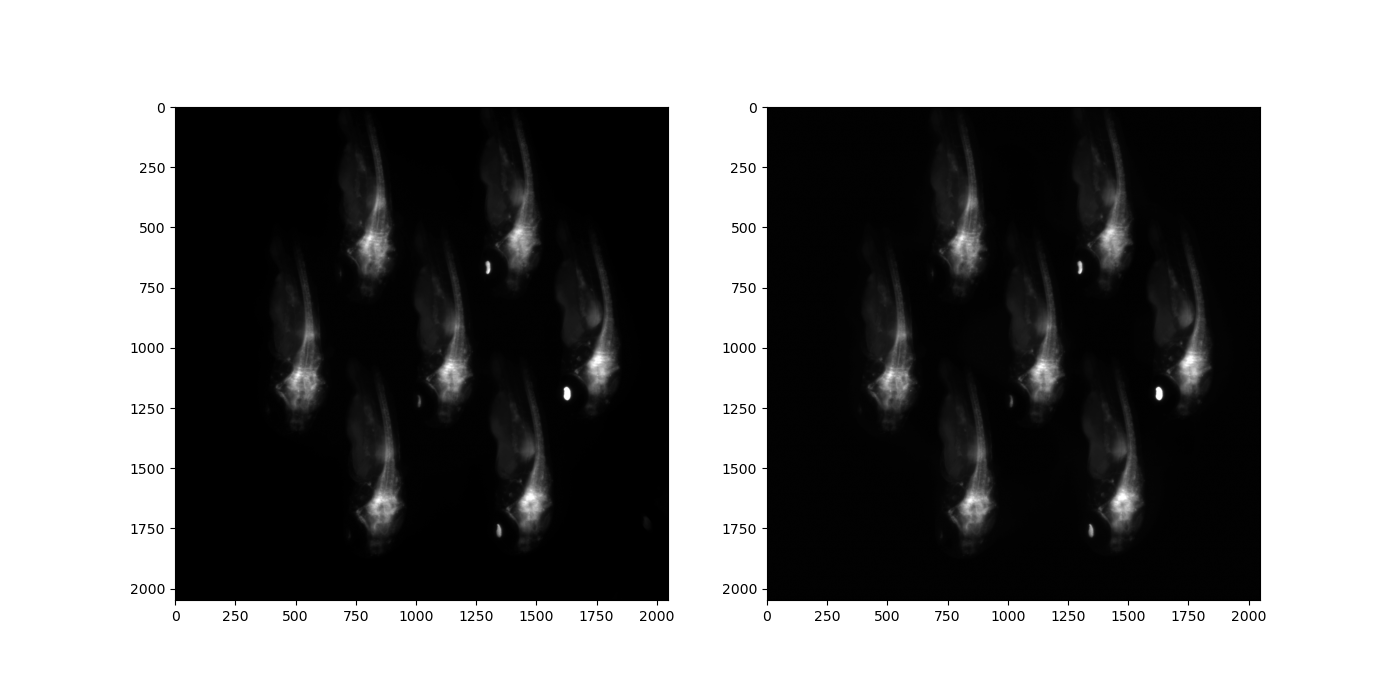

In [4]:
vmax=100


fig, ax = plt.subplots(1,2,figsize = (14,7))
bg = lazyh5(paths.bg)["data"][crop[0]:crop[1],crop[2]:crop[3]]
with h5py.File(paths.raw, "r") as f:
    ims = np.array(f["data"][25:50,crop[0]:crop[1],crop[2]:crop[3]])
im = ims[0]

ax[0].imshow(im, cmap = "gray",vmax=vmax)
ax[1].imshow((im-bg)*mask, cmap="gray",vmax=vmax)
print(dataset_name)

In [9]:
def normalize_mean(arr):
    return arr/arr.mean()

(0.0, 100000.0)

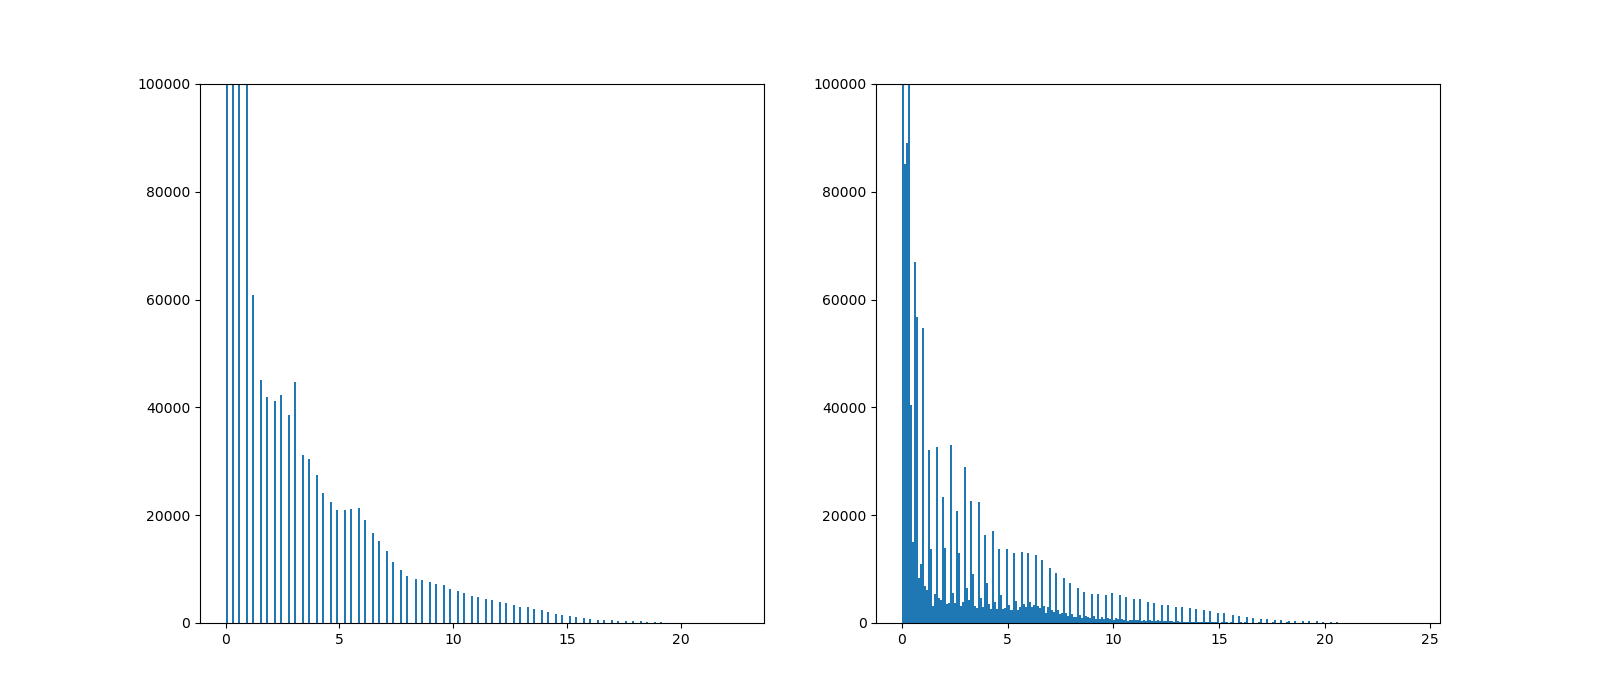

In [11]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ax[0].hist(normalize_mean(im.flatten()),bins=255)
ax[0].set_ylim(0,100000)
ax[1].hist(normalize_mean(((im-bg).clip(0,None)*mask).flatten()),bins=255)
ax[1].set_ylim(0,100000)


In [ ]:
# cx, cy, radii, masks = get_lenses(og_mask, radius_range=np.arange(525,535))
cx=np.array(psf_f["ml_cx"])
cy=np.array(psf_f["ml_cy"])
radii=np.array(psf_f["ml_radii"])
masks=np.array(psf_f["ml_masks"])

import video
importlib.reload(video)
from video import recording_to_overlay_preview, get_lenses, img_to_overlay_preview, showvid, get_projection_image
fn_vid, fn_file ,fn_dff_vid, fn_dff_file = recording_to_overlay_preview(paths,
                                                      cx,cy,padxy=300,masks=masks, 
                                                      fps=40, 
                                                      avg_method="median", median_avg_window =40, 
                                                      dff=True,
                                                      vmin=0,vmax=100,absolute_limits=False)
showvid(fn_vid)

In [5]:
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs
img_idx = [25,26,1]
# print(f"PSF zspacing: {np.abs(np.diff(psf["z_positions"][::2])).mean()*1000} um")
objs, mips, losses, kwargs = reconstruct_vols_from_imgs(paths,
                                                        img_idx=img_idx,
                                                        crop = crop,
                                                        max_iter = 100,
                                                        roi_size=500,
                                                        loss_threshold=0,
                                                        reuse_prev_vol = False,
                                                        psf_downsample = [0,None,2],
                                                        OTF_normalize=True,
                                                        OTF_clip=False,
                                                        img_subtract_bg=True,
                                                        img_mask=True,
                                                        img_normalize=True,
                                                        plot_decon=True,
                                                        fully_batched=False,
                                                        slice_idx=[35,428,609],
                                                        vmin=0,
                                                        vmax=100,
                                                        absolute_limits=True)


Loading OTF from disk


Reconstructing volumes:   0%|          | 0/1 [00:00<?, ?it/s]

Deconvolving image 1/1:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
import video

importlib.reload(video)
from video import array3d_to_video
fn_vid = os.path.join(paths.pn_outrec , f"deconv_mips_{kwargs["vmin"]}-{kwargs["vmax"]}{'_al' if kwargs["absolute_limits"]else''}.mp4")
array3d_to_video(mips[0], fn_vid)
print("test")
play_video_widget(fn_vid)

Creating video:   0%|          | 0/100 [00:00<?, ?it/s]

test


In [7]:
import widgets
importlib.reload(widgets)
from widgets import ortho_views_widget
ortho_views_widget(objs[0], vmin=0, vmax=10, gpu=False)

OrthoViewsWidget(coords=[56, 496, 496], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

Creating video:   0%|          | 0/100 [00:00<?, ?it/s]

'/home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/testmip/deconv_f25_roi500_img_masked_vmin0_vmax5_al_OTF_20250701_1216_PSF_LB_noap_1_pad201_norm_dwn[60, -30, 1].mp4'

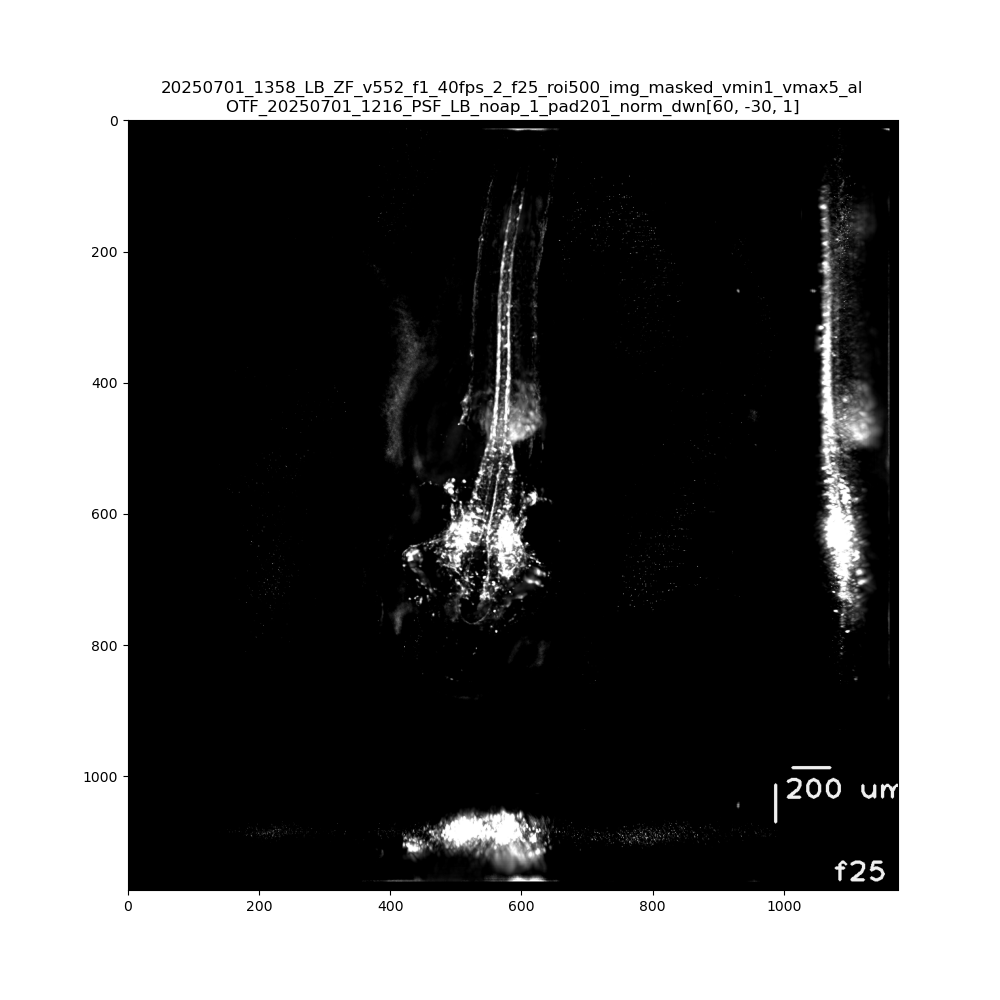

In [ ]:
import video
importlib.reload(video)

from video import create_projection_image, array3d_to_video

frame = 0

vmin=1
vmax=5
absolute_limits=True
_zpos = zpos[kwargs["psf_downsample"][0]:kwargs["psf_downsample"][1]:kwargs["psf_downsample"][2]] if kwargs["psf_downsample"] is not None else zpos


fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(create_projection_image(objs[0], vmin=vmin, vmax=vmax, absolute_limits=absolute_limits, zpos = _zpos, scalebar=200, text = f"f{np.arange(*img_idx)[frame]}",),cmap = "gray")

title = f"f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{vmin}_vmax{vmax}{"_al" if absolute_limits else ""}"
deconv_title = f"deconv_f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{kwargs["vmin"]}_vmax{kwargs["vmax"]}{"_al" if kwargs["absolute_limits"] else ""}"
otf_name = f"OTF_{paths.psf_name}_pad{kwargs["xy_pad"]}{"_clip" if kwargs["OTF_clip"] else ""}{"_norm" if kwargs["OTF_normalize"] else ""}{f'_dwn{kwargs["psf_downsample"]}' if kwargs["psf_downsample"] is not None else ''}"

ax.set_title(paths.dataset_name+"_"+title +"\n"+otf_name)
os.mkdir(os.path.join(paths.pn_outrec,"testmip")) if not os.path.exists(os.path.join(paths.pn_outrec,"testmip")) else None
fig.savefig(os.path.join(paths.pn_outrec,"testmip",f"{title}_{otf_name}.png"))

deconv_title = f"deconv_f{np.arange(*img_idx)[frame]}_roi{kwargs["roi_size"]}_img{"-bg" if kwargs["img_subtract_bg"] else ""}{"_masked"if kwargs["img_mask"] else ""}_vmin{kwargs["vmin"]}_vmax{kwargs["vmax"]}{"_al" if kwargs["absolute_limits"] else ""}"
otf_name = f"OTF_{paths.psf_name}_pad{kwargs["xy_pad"]}{"_clip" if kwargs["OTF_clip"] else ""}{"_norm" if kwargs["OTF_normalize"] else ""}{f'_dwn{kwargs["psf_downsample"]}' if kwargs["psf_downsample"] is not None else ''}"


array3d_to_video(mips[0],  os.path.join(paths.pn_outrec,"testmip",f"{deconv_title}_{otf_name}.mp4")) # doesnt change the vmax in the vid. redo the deconvolution to update this one

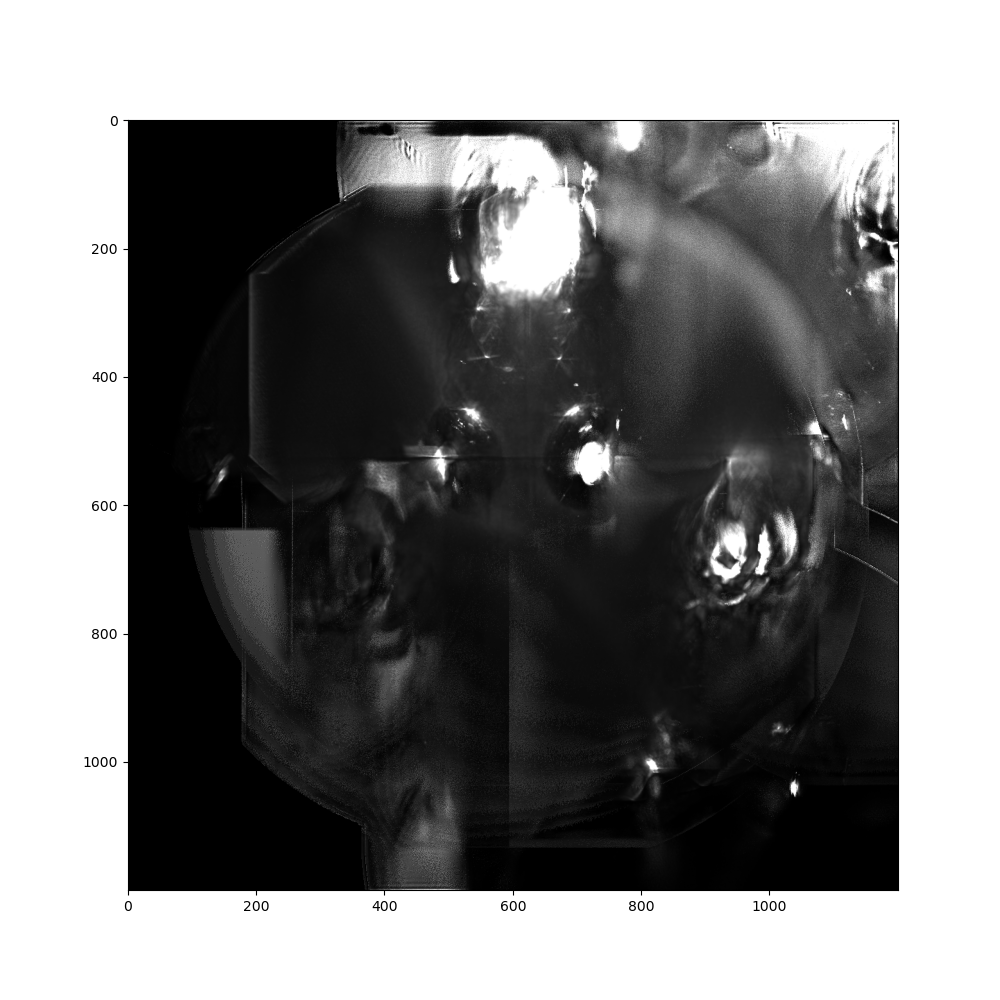

In [14]:
x1, y1 = 500, 80 #top left
x2, y2 = 750, 550 #bottom right

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(objs[0].max(axis=0), cmap = "gray", vmax=10)
rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="cyan", facecolor="cyan", alpha=0.3
    )
ax.add_patch(rect)
out_crop = (y1,y2,x1,x2)
kwargs["out_crop"] = out_crop

In [15]:
kwargs["vmax"] = 5
kwargs["transpose"]=False
kwargs

{'max_iter': 50,
 'xy_pad': 201,
 'roi_size': 600,
 'loss_threshold': 0,
 'reuse_prev_vol': False,
 'psf_downsample': [0, None, 1],
 'OTF_normalize': True,
 'OTF_clip': False,
 'crop': array([   0, 2048,    0, 2048]),
 'img_subtract_bg': False,
 'img_mask': True,
 'fully_batched': False,
 'vmin': 0,
 'vmax': 5,
 'absolute_limits': True,
 'transpose': False,
 'out_crop': (80, 550, 500, 750)}

## Deconvolve the whole recording

In [16]:
import slurm
importlib.reload(slurm)
from slurm import PythonExecutorSLURM
import reconstruction
importlib.reload(reconstruction)
from reconstruction import reconstruct_vols_from_imgs_parallel
kwargs, save_fn, vid_fn = reconstruct_vols_from_imgs_parallel(paths,img_idx=None,write_mip_video=True,**kwargs)
# print(save_fn,"\n",vid_fn)


Loading OTF from disk
Setting up I/O queues
Writing into new file: /home/lubo12/hpc-rw/lfm/results/20250729_1557_LB_DC8_5dpf_backfill_1_2fps/deconvolved.h5
AsyncH5Writer error: Object dtype dtype('O') has no native HDF5 equivalent
Traceback:


Traceback (most recent call last):
  File "/home/lubo12/LFM/imaging/i_o.py", line 271, in _writer_thread
    self._write_dict_to_group(f, group_name, meta_dict)
  File "/home/lubo12/LFM/imaging/i_o.py", line 301, in _write_dict_to_group
    recursive_write(g, d)
  File "/home/lubo12/LFM/imaging/i_o.py", line 296, in recursive_write
    g.create_dataset(k, data=v)
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/h5py/_hl/group.py", line 183, in create_dataset
    dsid = dataset.make_new_dset(group, shape, dtype, data, name, **kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/h5py/_hl/dataset.py", line 87, in make_new_dset
    tid = h5t.py_create(dtype, logical=1)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "h5py/h5t.pyx", line 1669, in h5py.h5t.py_create
  File "h5py/h5t.pyx", line 1693, in h5py.h5t.py_create
  File "h5py/h5t.pyx", line 1753, in h5py.h5t.py_create
Type

GPU 0: Initializing Memory


GPU 0: Deconvolving image 1/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 2/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 3/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 4/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 5/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 6/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 7/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 8/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 9/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 10/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 11/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 12/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 13/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 14/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 15/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 16/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 17/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 18/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 19/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 20/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 21/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 22/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 23/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 24/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 25/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 26/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 27/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 28/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 29/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 30/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 31/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 32/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 33/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 34/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 35/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 36/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 37/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 38/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 39/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 40/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 41/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 42/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 43/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 44/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 45/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 46/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 47/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 48/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 49/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 50/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 51/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 52/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 53/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 54/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 55/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 56/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 57/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 58/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 59/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 60/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 61/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 62/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 63/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 64/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 65/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 66/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 67/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 68/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 69/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 70/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 71/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 72/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 73/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 74/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 75/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 76/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 77/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 78/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 79/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 80/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 81/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 82/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 83/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 84/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 85/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 86/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 87/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 88/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 89/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 90/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 91/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 92/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 93/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 94/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 95/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 96/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 97/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 98/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 99/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 100/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 101/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 102/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 103/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 104/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 105/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 106/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 107/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 108/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 109/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 110/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 111/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 112/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 113/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 114/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 115/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 116/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 117/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 118/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 119/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 120/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 121/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 122/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 123/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 124/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 125/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 126/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 127/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 128/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 129/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 130/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 131/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 132/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 133/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 134/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 135/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 136/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 137/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 138/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 139/140:   0%|          | 0/50 [00:00<?, ?it/s]

GPU 0: Deconvolving image 140/140:   0%|          | 0/50 [00:00<?, ?it/s]

Deconvolution finished in 00:37:31


In [ ]:
email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='deconv'+paths.dataset_name, conda_env='lfm1',
                                     time="0-12:00", partition="pgpu", gres="gpu:4", cpus_per_task=16,mem='128G',ntasks=1,nodes=1,exclude="s-sc-pgpu03",
                                     cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')

In [ ]:
job_id = slex.submit(reconstruct_vols_from_imgs_parallel, paths, **kwargs, verbose=2)
print(paths.dataset_name)

Submitted batch job 5522376

20250701_1358_LB_ZF_v552_f1_40fps_2


## Setup registration

In [37]:
importlib.reload(reconstruction)
from reconstruction import percentile_normalization
percentile_normalization(np.arange(20), low_percentile=0, high_percentile=100)
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
ref_vol_idx=[0,10,1] #should have no movement
fn_raw_ref_vid = os.path.join(paths.pn_outrec, "ref_raw.mp4")


ref_vid_writer = AVWriter2(, fps=10, expected_indeces=range(*ref_vol_idx))
ref_reader = VolumeReader(paths.raw, "data", ref_vol_idx)
for i, frame in ref_reader:
    font, lineType = cv2.FONT_HERSHEY_PLAIN, text_size+1
        text_width, text_height = cv2.getTextSize(text, font, text_size, lineType)[0]
    frame =cv2.putText(frame, f"f{i}", 
                             org=10, 
                             fontFace=font,
                             fontScale=text_size, 
                             color = color,
                             thickness=lineType)   


In [ ]:
test_reg_idx=[100, 120] #ideally has movement

In [ ]:
result.deconvolution_params["OTF"]

In [ ]:
import video
importlib.reload(video)
from video import recording_to_video
video_fn = recording_to_video(paths, fps=40, vmax=15, absolute_limits=True)
#it took 1:20:00

Creating video:   0%|          | 0/4020 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import cupy as cp
cp.array([1,0,1],dtype=bool)

array([ True, False,  True])

In [ ]:

import video
importlib.reload(video)
import i_o
importlib.reload(i_o)
from video import recording_to_video, array3d_to_video
import time
start = time.time()
# video_fn = recording_to_video(paths, fps=40, vmax=20, absolute_limits=True)
print("it took", time.time()-start)

it took 2.384185791015625e-05
